# Capstone: Airbnb Price Listing Prediction
## Part 4 Model Tuning

_Authors: Evonne Tham_

In the previous notebook, the XGBoost produced a high $R^2$ score of 0.9665 and 7.849000e-01 for the train and validation sets respectively, and an $RMSE$ of 8995.01. Despite this, the model needs to be tuned by narrowing the features from 324 features to a more manageable number so that the model is more generalisable and for inferences about the data to be easily made. 

This will be done by utilising the features importance, a built-in function in XGBoost, after they have been modelled. This model will be used as the production model in the next notebook.

## Contents of this notebook
1. [Import Necessary Libraries and Load Data](#1.-Import-Necessary-Libraries-and-Load-Data)
2. [Re-training the Best Model (XGBoost)](#2.-Re-training-the-Best-Model-(XGBoost))
3. [Feature Selection](#3.-Feature-Selection)
4. [Re-training the XGBoost with Selected Features](#4.-Re-training-the-XGBoost-with-Selected-Features) 


## 1. Import Necessary Libraries and Load Data

In [16]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# modelling
import time
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler 
from sklearn.linear_model import LinearRegression, ElasticNetCV
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score

# from sklearn.metrics import explained_variance_score, mean_squared_error, r2_score, accuracy_score
# from xgboost import plot_importance


#Hide warnings
import warnings
warnings.filterwarnings('ignore')

In [17]:
# Load in Data 
train = pd.read_csv('../datasets/train.csv')

#Set id as index 
train.set_index('id', inplace=True)

print(f"Total Number of Listing: {train.shape[0]} | Total Number of Features: {train.shape[1]}")

Total Number of Listing: 9148 | Total Number of Features: 323


---
## 2. Re-training the Best Model (XGBoost)

In [18]:
# Create X and y variables
features = [col for col in train._get_numeric_data().columns if col != 'price']
X = train[features]
y = train['price']

# Train/Validation Split
X_train, X_val, y_train, y_val = train_test_split(X, 
                                                  y, 
                                                  test_size=0.25,
                                                  random_state = 42) 

rs = RobustScaler()
X_train_rs = rs.fit_transform(X_train)
X_val_rs = rs.transform(X_val)

In [22]:
# Instantiate Best Model
xgb = XGBRegressor(gamma = 0,
                   learning_rate = 0.05, 
                   max_depth = 5, 
                   n_estimators = 1000, 
                   subsample = 0.3)

# Fit Model
xgb.fit(X_train_rs, y_train)

#Predict target values
pred = xgb.predict(X_val_rs)
residuals = y_val - pred

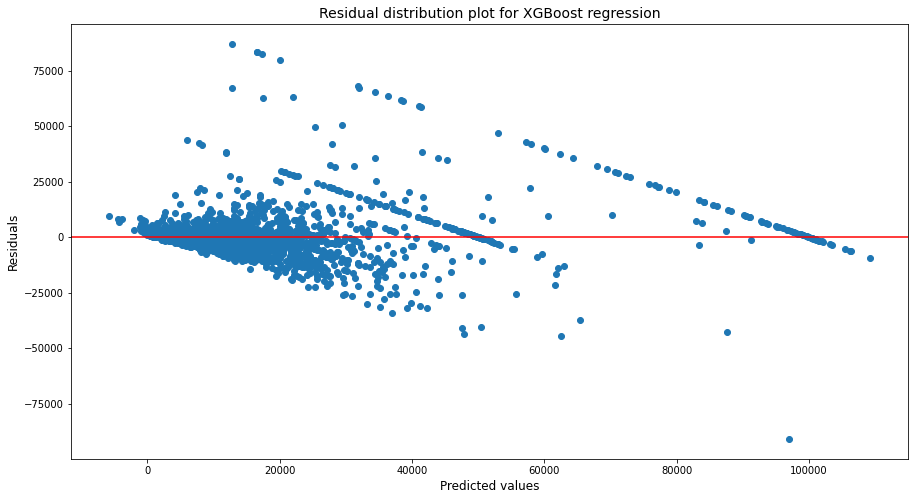

In [23]:
# Plot Residuals
plt.figure(figsize=(15,8))

plt.scatter(pred, residuals)
plt.axhline(0, linestyle='-', color='r')
plt.title('Residual distribution plot for XGBoost regression', fontsize=14)
plt.xlabel('Predicted values', fontsize=12)
plt.ylabel('Residuals', fontsize=12);

--- 
## 3. Feature Selection

### 3.1. Feature Importances

In [33]:
# Visualizing top features in our production model. 
key_features = pd.DataFrame([xgb.feature_importances_], columns = X.columns).T
key_features.sort_values(0, ascending = False, inplace = True)
key_features.head()

,0
neighbourhood_Chuo Ku,0.106578
room_type_entire_home_apt,0.037121
fixed grab bars for shower,0.016093
minimum_nights,0.012587
paid parking off premises,0.012150


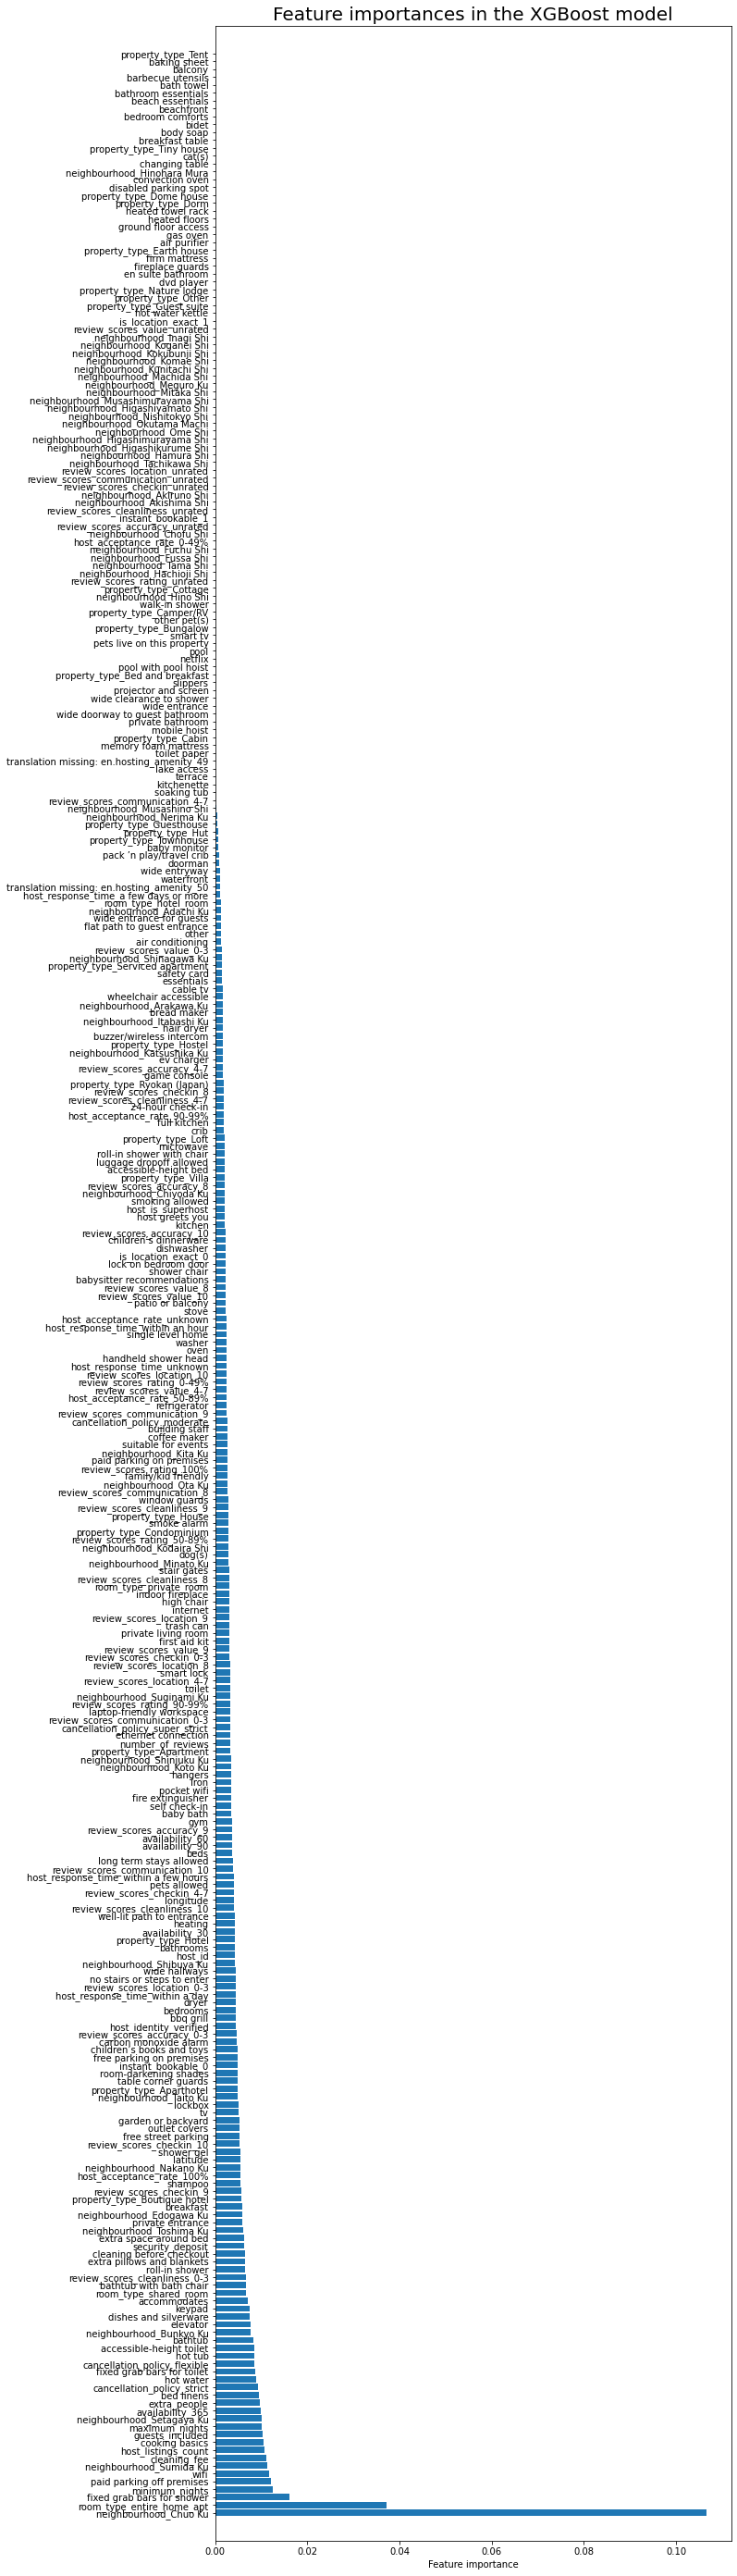

In [39]:
# Plotting feature importances
plt.figure(figsize=(10,50))
plt.barh(key_features.index, key_features[0], align='center') 
plt.title("Feature importances in the XGBoost model", fontsize=20)
plt.xlabel("Feature importance")
plt.margins(y=0.01)
plt.show()

### 3.2. Dropping Features

## 4. Re-training the XGBoost with Selected Features

## 5. Learning Curve

In [ ]:
# from sklearn.model_selection import learning_curve
# import matplotlib.pyplot as plt
# plt.style.use('ggplot')
# %matplotlib inline

# def plot_learning_curve(estimator, clf, X, y, ylim=None, cv=None, train_sizes=None):
#     plt.figure()
#     plt.title(f'Learning Curves ({clf})')
#     plt.ylim(*ylim)
#     plt.xlabel("Training examples")
#     plt.ylabel("Score")
#     train_sizes, train_scores, test_scores = learning_curve(
#         estimator, X, y, cv=cv, train_sizes=train_sizes)
#     train_scores_mean = np.mean(train_scores, axis=1)
#     train_scores_std = np.std(train_scores, axis=1)
#     test_scores_mean = np.mean(test_scores, axis=1)
#     test_scores_std = np.std(test_scores, axis=1)

#     plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
#                      train_scores_mean + train_scores_std, alpha=0.1,
#                      color="r")
#     plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
#                      test_scores_mean + test_scores_std, alpha=0.1, color="g")
#     plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
#              label="Training score")
#     plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
#              label="Cross-validation score")

#     plt.legend(loc="best")
#     plt.grid(True)
#     return

In [ ]:
# train_sizes = np.linspace(.1, 1.0, 5)
# ylim = (0.9, 1.01)
# cv = 5

# plot_learning_curve(pipe_lr, "Linear Regression", X_val, y_val, 
#                     ylim=ylim, cv=cv, train_sizes=train_sizes)
# plot_learning_curve(pipe_enet, "ElasticNetCV", X_val, y_val, 
#                     ylim=ylim, cv=cv, train_sizes=train_sizes)
# plot_learning_curve(pipe_svr, "SVR", X_val, y_val, 
#                     ylim=ylim, cv=cv, train_sizes=train_sizes)
# plot_learning_curve(pipe_xgb, "XGBoost", X_val, y_val,
#                     ylim=ylim, cv=cv, train_sizes=train_sizes)

# plt.show()

----> Proceed to the next notebook for [Production Model](./05_Production_Model.ipynb)